<a href="https://colab.research.google.com/github/rylan-berry/DataScienceExercises2025-2026/blob/main/RylaBerrU5Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mississippi River Discharge Over Time

###Imports

In [34]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm
import graphviz as gv
from scipy.interpolate import PchipInterpolator

##Context
The Mississippi river is the largest river in the United States, and is constantly has large quantities of water flowing throught it. But the question is how has the volume of water flowing through the river changed over the years.

##Previous Knowlegde

As our world has warmed due to climate change, more water has evaportated into the air, and hence has come down as rain. So, as the earth has continued to warm up, then so should the rain, and hence the ammount of water in the Mississippi river, and how much is discharged into the ocean.

##Data Collection

The data was collected by the Data Science teacher. The dataset uses discharge as the flow rate, and it includes the year and the month of each recording. For this analysis, we'll specifically use the month of January for this analysis, since precipitation changes from season to season (so using all the months at once would be more scattered), and from observing some months individually January seems to most likely to demonstrate a trend at all.

In [35]:
missriver = pd.read_csv("https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/missriver1.csv")
missriver

,year,yrMonth,serMonth,discharge
0,1916,1,1,63.69
1,1916,2,2,81.00
2,1916,3,3,125.42
3,1916,4,4,272.29
4,1916,5,5,427.68
...,...,...,...,...
871,1988,8,872,82.75
872,1988,9,873,57.26
873,1988,10,874,36.00
874,1988,11,875,63.25


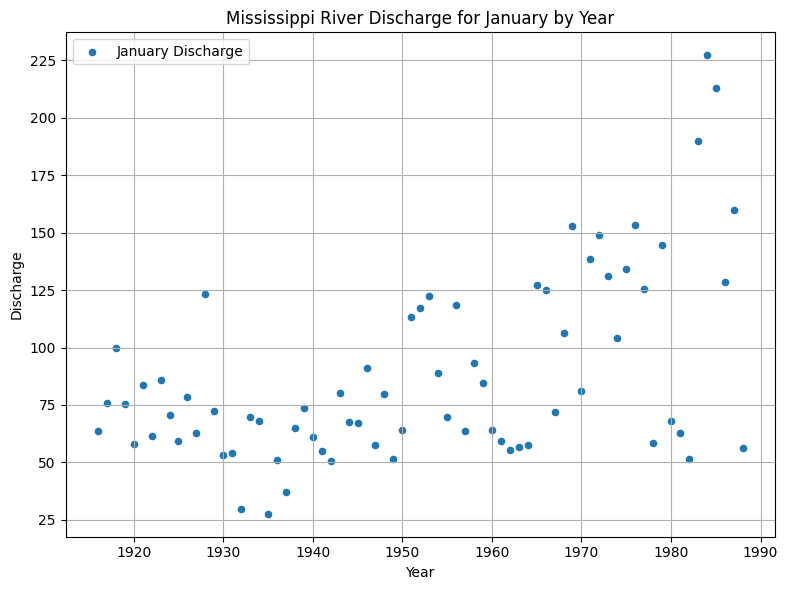

In [36]:
#code generated by gemini
january_data = missriver[missriver['yrMonth'] == 1]

fig, ax = plt.subplots(figsize=(8, 6))

january_data.plot(x="year", y="discharge", kind="scatter", ax=ax, label="January Discharge")

ax.set_title("Mississippi River Discharge for January by Year")
ax.set_xlabel("Year")
ax.set_ylabel("Discharge")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##Likelyhood and Priors

The data seems to be parabolic, from 1916-1935 appearing to be decreasing, while after 1935 seems to be increasing. So, the priors should try to have the vertex around 1935 and at about a discharge of 50, and the function should be positive.

##The Model

In [ ]:
#Gemini adjustments around centering the year of the model
with pm.Model() as model_missriv:

    # Recenter the year so that 1916 is year 0
    centered_year = january_data.year - 1916

    #priors for trend line
    α = pm.Normal("α", sigma=20)
    β = pm.Normal("β", sigma=10)
    c = pm.Normal("c", sigma=20)

    #priors for the line for our standard deviation
    γ = pm.HalfNormal("γ", sigma=20)
    δ = pm.HalfNormal("δ", sigma=10)
    j = pm.HalfNormal("j", sigma=20)

    #mean line using centered_year
    μ = pm.Deterministic("μ", α + β * (centered_year)**2 + c * centered_year)

    #standard deviation line; this allows our variance to vary over th x values using centered_year
    σ = pm.Deterministic("σ", γ + δ * (centered_year)**2 + j * centered_year)

    #normal likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=january_data.discharge)

    # Increase target_accept to mitigate divergences
    idata_missriv = pm.sample(target_accept=0.9)

In [ ]:
pm.sample_posterior_predictive(idata_missriv, model=model_missriv,  extend_inferencedata=True)

Text(0, 0.5, 'discharge')

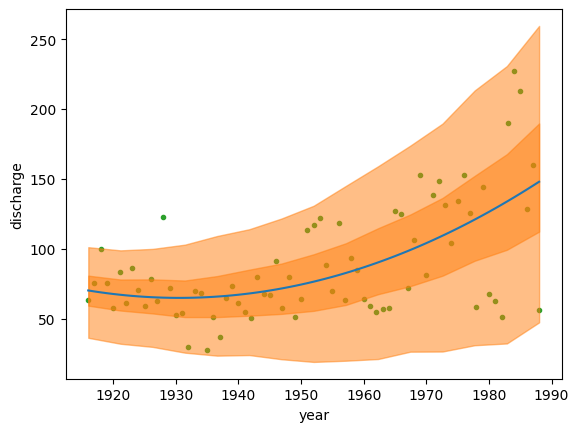

In [45]:
mean_line = idata_missriv.posterior["μ"].mean(("chain", "draw"))
year = np.random.normal(january_data.year.values, 0.01)
idx = np.argsort(year)
x = np.linspace(year.min(), year.max(), 15)
y_pred_q = idata_missriv.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(year[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)
_, ax = plt.subplots()
ax.plot(january_data.year, january_data.discharge, "C2.", zorder=-3)
ax.plot(january_data.year.values[idx], mean_line.values[idx], c="C0")
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)
ax.set_xlabel("year")
ax.set_ylabel("discharge")

<Axes: xlabel='y_pred'>

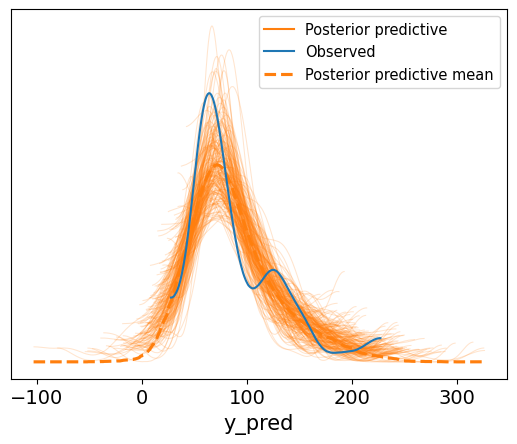

In [46]:
az.plot_ppc(idata_missriv, num_pp_samples=200, colors=["C1", "C0", "C1"])

##Conclusion

Over the period this data was observed, the model demonstates that there **is** a parabolic relationship between discharge and time. More importantly, over more recent decades, the volume of water going through the Mississippi river has been parabollically increasing. Which is likely the result of climate change.